# Using a Genetic Algorithm for optimal control

In this notebook, we use a Genetic algorithm to optimize the pulse sequence to send to the Rydberg atom register in order to prepare a specific state. In this case, the goal is to prepare one of two Antiferromagnetic states (up-down-up-down...) on a N-site periodic chain, which is defined as an equal mixture of the two "checkerboard" spin states (see figure below). This is a first easy task to test the genetic optimizer, before moving on to more general graphs where the AF state is the MIS problem solution. 

<center>
<img src="images/afstate.png" width="500px"/>
</center>

Much of the pulse interpretation code and AF state fidelity is taken from the "Bayesian optimization for antiferromagnetic state preparation" in the Pulser tutorials (see https://pulser.readthedocs.io/en/stable/tutorials/optimization.html). We are grateful for the open access to those!

In [1]:
#first some packages

import time

import numpy as np
import matplotlib.pyplot as plt
import qutip
import networkx as nx
%matplotlib inline

import matplotlib.cm as cm
import pandas as pd
import json

from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import Chadoq2

import warnings
warnings.filterwarnings('ignore')

## System and Parameters
The parameters which will bound the parameter space during the optimisation are set within device specification. A square register of $4\times 4$ atoms with a central $2\times 2$ square of atoms missing is created. It is equivalent to a chain of $12$ atoms but avoids edge effects which alter the system dynamics.

Interatomic Radius is: 6.979121718087879µm.


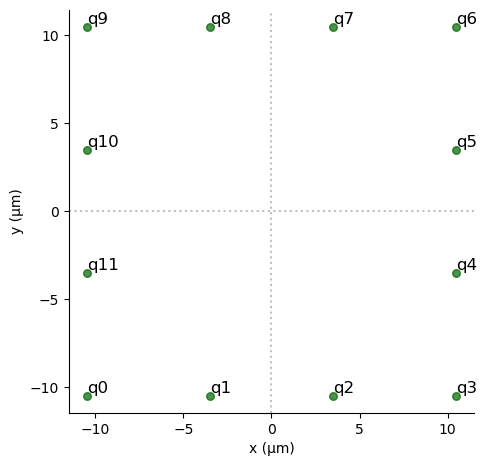

In [2]:
# Parameters in rad/µs and ns

T = 1000  # duration of the pulse
U = 2 * np.pi * 5.0 #the max interaction

Omega_max = 0.5 * U #less than the Full J

delta_0 = -1.0 * U #start in the all down state (un-occupied)
delta_f = 1.0 * U #try to occupy as many states in the Rydberg state

R_interatomic = Chadoq2.rydberg_blockade_radius(Omega_max) / 1.2
print(f"Interatomic Radius is: {R_interatomic}µm.")

N_side = 4
coords = (
    [R_interatomic * np.r_[x, 0] for x in range(N_side - 1)]
    + [R_interatomic * np.r_[N_side - 1, y] for y in range(N_side - 1)]
    + [
        R_interatomic * np.r_[N_side - 1 - x, N_side - 1]
        for x in range(N_side - 1)
    ]
    + [R_interatomic * np.r_[0, N_side - 1 - y] for y in range(N_side - 1)]
)
reg = Register.from_coordinates(coords, prefix="q")
N = len(coords)
N_samples = 1000
reg.draw()

A channel is declared on the Chadoq2 device in order to check the feasibility of the pulses. If the extreme values of $\Omega_{max}$, $\delta_0$ and $\delta_f$ exceed the thresholds proposed by Chadoq2, a restriction is required. The best case scenario is to take extreme values which coincide with those of the device (within a certain tolerance), especially for $\delta_0$ and $\delta_f$ since they parameterise the adiabatic evolution of the system. 

In [3]:
from IPython.display import display, Latex

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

tol = 1e-6
max_amp = seq.declared_channels["ising"].max_amp * (1 - tol)
max_det = seq.declared_channels["ising"].max_abs_detuning * (1 - tol)
Omega_max = min(max_amp, Omega_max)
delta_0 = np.sign(delta_0) * min(max_det, abs(delta_0))
delta_f = np.sign(delta_f) * min(max_det, abs(delta_f))
display(Latex(f'$\Omega(max)/U$, $\delta_0/U$, $\delta_f/U$'))
print(Omega_max / U, np.round(delta_0 / U, 2), delta_f / U)

<IPython.core.display.Latex object>

0.4999995 -1.0 1.0


### Interpolated pulses
The parameters fed to the optimisation algorithm must uniquely define $\Omega$ and $\delta$. Interpolated pulses, once the interpolation method has been set, can be fully described by $2m + 1$ parameters, which are $T$ the total pulse time and $\{\Omega(t_i),\delta(t_i), i\in[1,m]\}$ with $t_i=T\times i/(m+1)$. The larger $m$ is, the more complex the pulse behaviour could be but also the more resources are needed since the parameters space is expanding. Here, the interpolation is done through the `InterpolatedWaveform` class, which does monotonic cubic splines using `PchipInterpolator` by default.

<center>
<img src="images/pulse_interp.png" width="800"/>
</center>

In [5]:
#---# example of a random sequence #----#
# Size of the parameter space
m = 3

# Random instance of the parameter space
amp_params = np.random.uniform(0, Omega_max, m)
det_params = np.random.uniform(delta_0, delta_f, m)
print('Omega params:{}'.format(amp_params))
print('delta params:{}'.format(det_params))

Omega params:[ 5.1894112  11.89192696  7.79415822]
delta params:[ 8.69997257 17.50605977  2.77013887]


We define an interpolation function which takes as argument a set of parameters and returns the interpolated pulse associated. Here, its starting and ending values are fixed such that $\Omega (0) = \Omega(T) = 0$, $\delta(0) = \delta_0$ and $\delta(T) = \delta_f$. The phase is set to 0. 

**These constraints are important!** At $\delta_0 < 0$, the system is in the ground state where all atoms are in the non-excited state. At $\delta_f > 0$ we try to create the maximum occupation of atoms in the $|r>$ excited Rydberg state as possible (i.e. the $|\uparrow>$ spin state). The action of the intermediate $\Omega (t)$ values act as a transverse field creating quantum excitation during the annealing process.

In [6]:
def create_interp_pulse(amp_params, det_params, T):
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
        InterpolatedWaveform(T, [delta_0, *det_params, delta_f]),
        0,
    )

Using Pulser, a Sequence on the Chadoq2 device is defined,  and the pulse is added to it. This allows us to visualize it.  

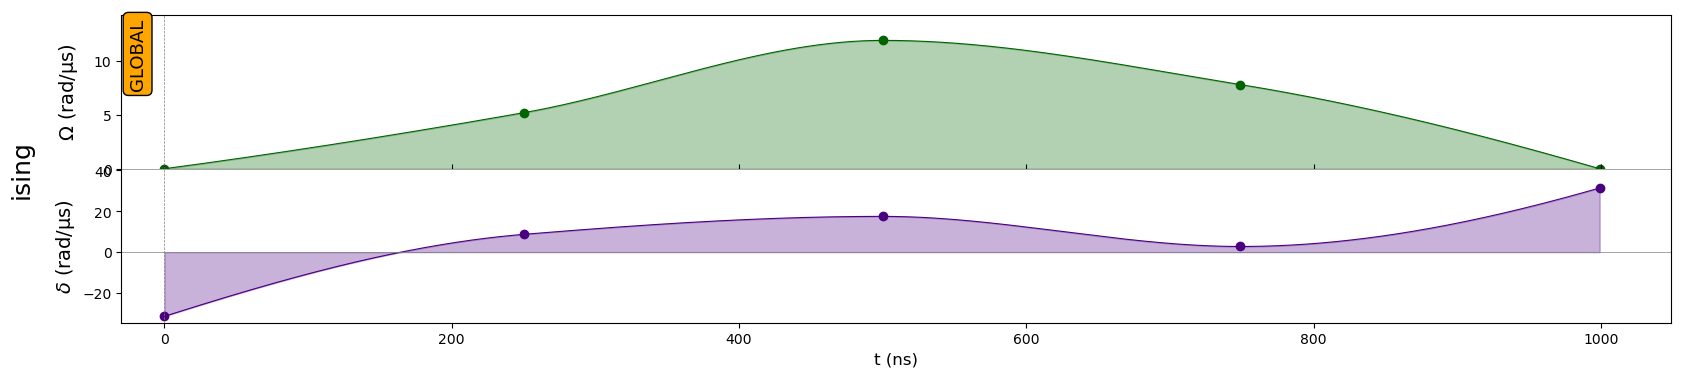

In [7]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(amp_params, det_params, T), "ising")
seq.draw()

Finally, the effect of this sequence can be run on the `Simulation` object. This takes longer and longer the more points in the sequence. 

In [8]:
simul = Simulation(seq)
results = simul.run()
final = results.get_final_state()

# Fidelity and Structure Factor

In order for the optimisation algorithm to distinguish between the good or bad result of different pulse sequences, and thus to browse the parameter space in search of an optimal shape of pulse, we need to assign a score to each set based on the state it allows us to reach. With the algorithm set to look for minimum, the AF state should have a score of 0 and all other states strictly positive score. The score will be defined based on the Néel structure factor $S_{Néel}$ since we want an observable accessible by the processor. This is the spin-spin correlation matrix with should have a clear $\pi$ structure in momentum space in the AF state.

In [10]:
def occupation(j, N):
    up = qutip.basis(2, 0) #get the up basis
    prod = [qutip.qeye(2) for _ in range(N)] #identity matrix for N elements
    prod[j] = up * up.dag() #at j-th site, only select up basis ((1,0), (0,0))
    return qutip.tensor(prod) #tensor product those matrices to get the S_z observable at site i


def get_corr_pairs(k, N): #k is the distance between 2 sites
    corr_pairs = [[i, (i + k) % N] for i in range(N)] 
    #valid for the N site ring, this gets all k-spaced pairs 
    return corr_pairs


def get_corr_function(k, N, state):
    corr_pairs = get_corr_pairs(k, N)
    operators = [occupation(j, N) for j in range(N)]
    covariance = 0
    for qi, qj in corr_pairs: #that's i and j
        covariance += qutip.expect(operators[qi] * operators[qj], state) # <S_i S_j>
        covariance -= qutip.expect(operators[qi], state) * qutip.expect(
            operators[qj], state
        ) #<S_i> <S_j>
    return covariance / len(corr_pairs)


def get_full_corr_function(reg, state):
    N = len(reg.qubits)
    correlation_function = {}
    for k in range(-N // 2, N // 2 + 1): #for all the dist-k neighbors
        correlation_function[k] = get_corr_function(k, N, state)
    return correlation_function #this then needs to be Fourier Transformed


def get_neel_structure_factor(reg, state):
    N = len(reg.qubits)
    st_fac = 0
    for k in range(-N // 2, N // 2 + 1):
        kk = np.abs(k)
        st_fac += 4 * (-1) ** kk * get_corr_function(k, N, state)
    return st_fac

We will use one of Pulser's methods (`sample_final_state()` which belongs to the `CoherentResults` class) to sample from the final state of a simulation's results, wrapped in a function that displays those bitstrings above a certain threshold probability `min_p`:

In [11]:
def proba_from_state(results, min_p=0.1):
    sampling = results.sample_final_state(N_samples=N_samples)
    return {
        k: f"{100*v/N_samples}%"
        for k, v in sampling.items()
        if v / N_samples > min_p
    }

$S_{Néel}$ should reach its maximum for the AF state, which we know. We can compute this value and use it as a benchmark to normalise the score. 

In [12]:
# Create antiferromagnetic state as the superposition of the two checkerboard patterns:
AF1 = qutip.tensor([qutip.basis(2, k % 2) for k in range(N)])
AF2 = qutip.tensor([qutip.basis(2, (k + 1) % 2) for k in range(N)])
AF_state = (AF1 + AF2).unit()

t1 = time.process_time()
S_max = get_neel_structure_factor(reg, AF_state)
print("S_Neel(AF state) =", S_max)
t2 = time.process_time()
print("computed in", (t2 - t1), "sec")

S_Neel(AF state) = 13.0
computed in 0.15008219999999994 sec


We then define the score function for a given sequence (given by params). Note that, at the moment, I have kept the total pulse time as a variable (generically it is 1000).

This gives a positive score for any sequence by comparing to the AF state. 

In [13]:
def score(params, m):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    #params[:m] is the m Omegas
    #params[m:] is the m deltas
    #params[2*m] is the total pulse time
    seq.add(create_interp_pulse(params[:m], params[m:2*m], params[2*m]), "ising")

    simul = Simulation(seq, sampling_rate=0.1)
    results = simul.run()

    sampling = results.sample_final_state(N_samples=N_samples)
    sampled_state = sum(
        [
            np.sqrt(sampling[k] / N_samples) * qutip.ket(k)
            for k in sampling.keys()
        ]
    )

    F = get_neel_structure_factor(reg, sampled_state) / S_max

    return 1 - F

A pulse example with m=3 points with total time of 1000


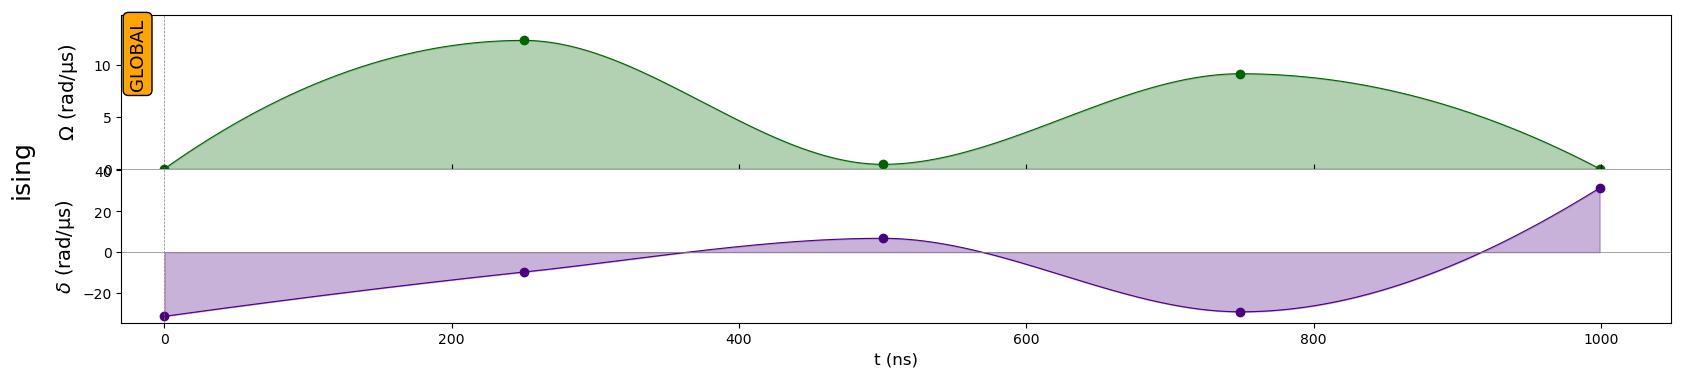

score of 0.8978784871794872


In [14]:
#test it for a random set of parameters
m = 3
#t_rand = np.random.uniform(T/10, T)
t_rand = T
print('A pulse example with m={} points with total time of {}'.format(m, t_rand))
# Random instance of the parameter space
amp_params = np.random.uniform(0, Omega_max, m)
det_params = np.random.uniform(delta_0, delta_f, m)
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(amp_params, det_params, t_rand), "ising")
seq.draw()
test_score = score(np.r_[amp_params, det_params, t_rand], m)
print('score of {}'.format(test_score))

# Genetic Optimization

Now that we have a means to construct a sequence and a means to evaluate its score, we can build our genetic optimizer!

Below we should add more text to describe it in detail.

First, some essential functions that do the following:
- Creating a random Pulse schedule
- Creating a simple 'benchmark' schedule for a hot start approach.
- Breeding two schedules together
- Mutating a given schedule
- Evaluate the score of the population
- Creating a new population out of an evaluated one
- Plot a given sequence

In [181]:
#a random anneal schedule that satisfies the constraints.
def create_random_schedule(npt):
    #random_anneal_time = np.random.uniform(T/10, T)
    random_anneal_time = T #keep it at always the same time
    random_schedule = np.zeros(2*npt + 1)
    random_schedule[2*npt] = random_anneal_time
    random_schedule[:npt] = np.random.uniform(0, Omega_max, npt)
    random_schedule[npt:2*npt] = np.random.uniform(delta_0, delta_f, npt)
    return random_schedule

#a benchmark linear ramp
def benchmark_schedule(npt):
    schedule = np.zeros(2*npt + 1)
    schedule[2*npt] = T
    #schedule[:npt] = (Omega_max - np.abs(np.linspace(-Omega_max, Omega_max, npt + 2)))[1:-1]
    schedule[:npt] = Omega_max*np.ones(npt)
    schedule[npt:(2*npt)] = np.linspace(delta_0, delta_f, npt+2)[1:-1]
    return schedule

#define the breeding and mutation functions
def breeding(parent1, parent2):
    num_of_points = len(parent1)
    #randomly select where you should end between each point:
    children = np.copy(parent1)
    for i in range(num_of_points-1):
        mid_point = np.random.rand()
        #mid_point = 0.5
        #v1 - the mean
        #children[i] = np.mean(parent1[i], parent2[i])
        #v2 - uniform distribution - more randomized breeding
        children[i] = mid_point*parent1[i] + (1-mid_point)*parent2[i]
    return np.array(children)

def mutation(children, mpts, mutation_rate_Omega, mutation_rate_delta):
    num_of_points = len(children)
    #choose a random site to affect
    new_child = np.copy(children)

    for ind in range(mpts):
        #Omega mutation
        while True:
            rand_num = np.random.normal(children[ind], mutation_rate_Omega)
            if (0 < rand_num < Omega_max):
                break
        new_child[ind] = rand_num    
        #delta mutation
        while True:
            rand_num = np.random.normal(children[ind + mpts], mutation_rate_delta)
            if (delta_0 < rand_num < delta_f):
                break
        new_child[ind+mpts] = rand_num 
    return np.array(new_child)

#Here, the lowest energy obtained during the anneal is kept as a fidelity
#this can be highly tailored
def evaluate_function(population, m):
    #get the score for all the members of the population
    evals = np.zeros(len(population))
    time_1 = time.time()
    for p in range(len(population)):
        evals[p] = score(population[p], m)
        #print('done with score of individual ', p)
    time_2 = time.time()
    timing = time_2 - time_1
    return evals, timing

#create a new population based on the past ones
def new_population(population, fidelity, N_elite, mutation_rate, mpts):
    #mutation_rate = [% of child that mutation, sigma of the mutation]
    N = len(population)
    #fidelity
    scaled_fidelity = (np.max(fidelity) - fidelity)/(np.max(fidelity) - np.min(fidelity))
    #sort them
    sorted_fidelity = np.argsort(fidelity) #this gives you the indices of the lowest fidelity to the highest - we are trying to minimize F
    #make scaled fidelity into a probability distribution
    prob_fidelity = scaled_fidelity/np.sum(scaled_fidelity)
    #choose a member for crossover, based on fitness
    #np.random.choice(np.arange(0,len(population),1, dtype=int), p=prob_fidelity)


    #number of elites is N_elite
    new_population = np.copy(population)
    #if count = 0, do not always keep first individual
    #if count = 1, always include the first individual (a benchmark anneal schedule)
    count = 0 
    #then keep the elite ones
    for i in range(N_elite):
        ind_elite = sorted_fidelity[i]
        new_population[count] = population[ind_elite]
        count += 1

    #note that the elite *might* also be the linear schedule. 
    #That's ok, it just means we do more annealings of the good schedule!

    #add children
    while count < N:
        #select pairs of parents
        cond_parents = True
        while cond_parents:
            #select pairs based on a fidelity probability distribution, where the best ones are chosen more frequently
            selected = np.random.choice(N,2,p=prob_fidelity)
            #selected = np.random.choice(N,2)
            if selected[0] != selected[1]: #parents need to be different!
                cond_parents = False #this breaks the while loop
            else:
                cond_parents = True

        #breed the parents to obtain child
        to_be_added = breeding(population[selected[0]], population[selected[1]])
        #sometimes, mutate the child
        if np.random.rand() < mutation_rate[0]:
            to_be_added = mutation(to_be_added, mpts, mutation_rate[1], mutation_rate[2])

        new_population[count] = to_be_added
        count += 1

    return new_population

def plot_a_sequence(individual,m):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(create_interp_pulse(individual[:m], individual[m:2*m], individual[2*m]), "ising")
    seq.draw()

In [182]:
#make random initial population of anneal_schedules
npt = 3 #number of points in the schedule
Npop = 10
population = []
population.append(benchmark_schedule(npt))
for j in range(Npop-1):
    population.append(create_random_schedule(npt))
population = np.array(population)

#define the genetic algorithm terms
N_elite = 2 #keep one elite as well as the linear benchmark, at all times.
mutation_rate = [0.5, 0.1*Omega_max, 0.1*(delta_f - delta_0)] 
#mutation_rate[0] -> probability. that an individual is chosen to mutate
#mutation_rate[1] -> variance of mutation of Omega points in schedule
#mutation_rate[2] -> variance of mutation of delta points in schedule

In [183]:
import sys
print("Starting Pulser calls and Genetic Optimization...")

iteration = 0
maxiter = 10

schedule_and_fidelities = pd.DataFrame(index=range(maxiter),
                                columns=["anneal_schedules", "fidelities"],
                                data=None)

total_time = 0
#initial fidelity
fidelity, timing = evaluate_function(population, npt)
schedule_and_fidelities.iloc[iteration]={"anneal_schedules":population,  
                            "fidelities":fidelity}
total_time += timing
iteration += 1
print("done w/ iteration {}, best Fidelity = {}".format(iteration, np.min(fidelity)))
print("Total time  {}".format(total_time))
#update pd for the first fidelity calculation

while iteration < maxiter:
    population = new_population(population, fidelity, N_elite, mutation_rate, npt)
    fidelity, timing = evaluate_function(population, npt)    
    schedule_and_fidelities.iloc[iteration]={"anneal_schedules":population,  
                                "fidelities":fidelity}
    iteration += 1
    total_time += timing
    print("done w/ iteration {}, best Fidelity = {}".format(iteration, np.min(fidelity)))
    print("Total time  {} s".format(total_time))
    sys.stdout.flush()
    if total_time > 60*10:
        break

Starting Pulser calls and Genetic Optimization...
done w/ iteration 1, best Fidelity = 0.47851566666666656
Total time  19.874650239944458
done w/ iteration 2, best Fidelity = 0.33252456410256415
Total time  49.34026885032654 s
done w/ iteration 3, best Fidelity = 0.2785977179487177
Total time  76.52570676803589 s
done w/ iteration 4, best Fidelity = 0.27963843589743587
Total time  103.84495997428894 s
done w/ iteration 5, best Fidelity = 0.10809058974358987
Total time  129.86682677268982 s
done w/ iteration 6, best Fidelity = 0.10993600000000003
Total time  156.61029171943665 s
done w/ iteration 7, best Fidelity = 0.10180256410256405
Total time  182.27805352210999 s
done w/ iteration 8, best Fidelity = 0.07392974358974358
Total time  208.87578177452087 s
done w/ iteration 9, best Fidelity = 0.06933443589743604
Total time  233.4874336719513 s
done w/ iteration 10, best Fidelity = 0.06993143589743578
Total time  257.1559944152832 s


# Performance

How did we do??

Need here to:
1. plot the results, with blocks vs n_calls (n_calls goes by steps of Npop)
2. We should see the result converging to lower and lower fidelities

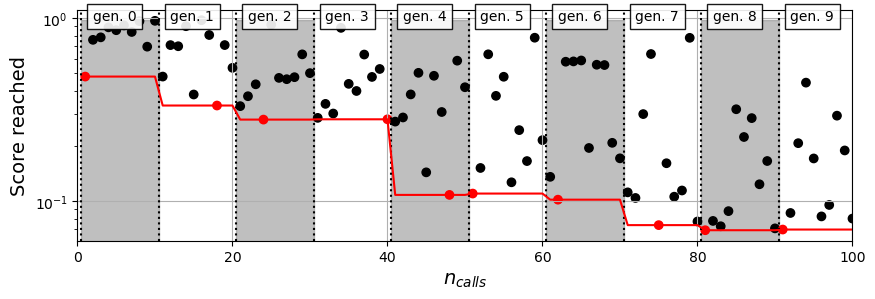

In [188]:
it_vals = []
fid_vals = []
colors = []
count = 1
it_max = iteration
overal_fid = []
for it in range(it_max):
    all_fidelities = schedule_and_fidelities.iloc[it]["fidelities"]
    min_index = np.argmin(all_fidelities)
    for j in range(len(all_fidelities)):
        it_vals.append(count)
        fid_vals.append(all_fidelities[j])
        overal_fid.append(all_fidelities[min_index])
        if j == min_index:
            colors.append('red')
        else:
            colors.append('black')
        count += 1

fig = plt.figure(figsize=(10,3))
#plt.legend(["1 run"], fontsize=12)
for it in range(it_max):
    plt.text(2+(it)*Npop, np.max(fid_vals), 'gen. {}'.format(it), bbox=dict(facecolor='white', alpha=0.9))
    plt.axvline(x=it*Npop+1/2, color='black', linestyle='dotted')
    if it %2 != 0:
        plt.fill_between([(it-1)*Npop+1/2, it*Npop+1/2], [np.max(fid_vals), np.max(fid_vals)], color='gray', alpha=0.5)
plt.scatter(it_vals, fid_vals, color=colors, marker='o')
plt.plot(it_vals, overal_fid, '-', color = 'red')
plt.yscale('log')
plt.xlabel(r"$n_{calls}$", fontsize=14)
plt.ylabel("Score reached", fontsize=14)
plt.xlim(0, it_max*Npop)
plt.grid()
plt.title(r'')
plt.show()

Note that since this is stochastic in nature, we should do many runs and average over those.

# Optimized pulse

The final interpolated pulse is given by:

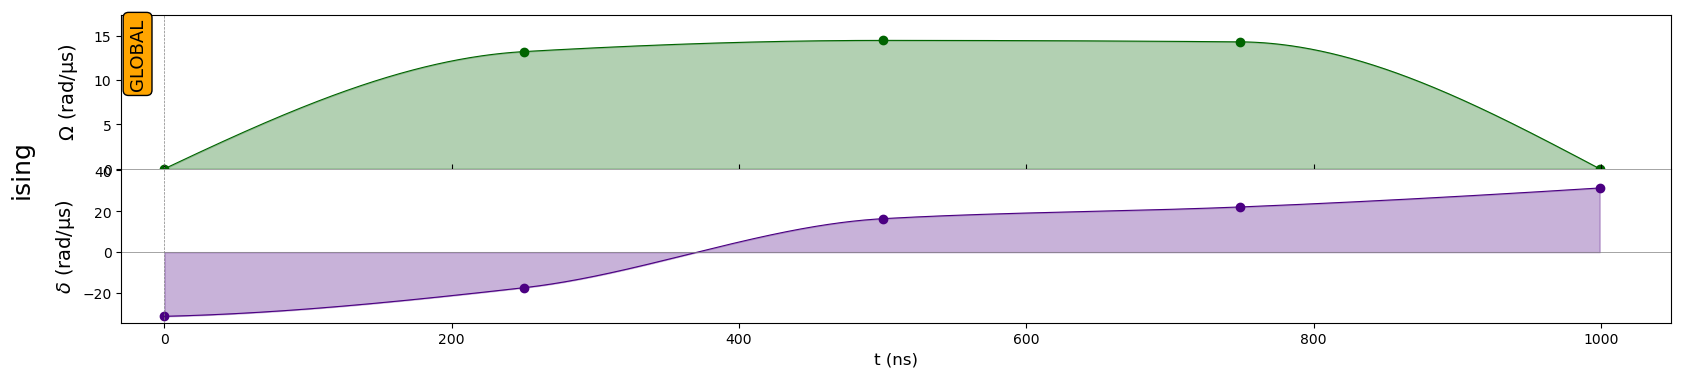

In [189]:
#pick the best fidelity of a pulse, which is the elite member 
#careful, index 0 is the linear benchmark
optimal_pulse = population[0]
plot_a_sequence(optimal_pulse, npt)

This is the result of using that pulse on the device:

In [190]:
#sequence declaration
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
P = create_interp_pulse(optimal_pulse[:npt], optimal_pulse[npt:(2*npt)], T)
seq.add(P, "ising")

#simulation
simul = Simulation(seq)
results = simul.run()
print("final =", proba_from_state(results, min_p=0.05))

sampling = results.sample_final_state(N_samples=1000)
sampled_state = sum(
    [np.sqrt(sampling[k] / 1000) * qutip.ket(k) for k in sampling.keys()]
)

s_neel_sampled = np.round(get_neel_structure_factor(reg, sampled_state), 3)
print(f"S_Neel (final_sampled) = {s_neel_sampled}")

final = {'010101010101': '48.5%', '101010101010': '43.4%'}
S_Neel (final_sampled) = 12.101


The pulse sequence travels though the following path in the phase diagram of the system (the shaded area represents the antiferromagnetic phase):

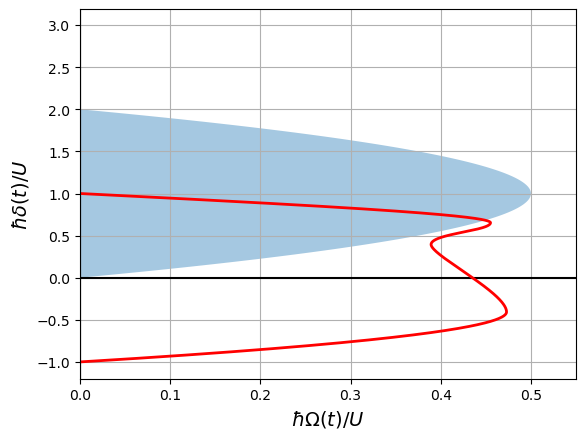

In [180]:
omega = P.amplitude.samples / U
delta = P.detuning.samples / U

fig, ax = plt.subplots()
ax.grid(True, which="both")

ax.set_ylabel(r"$\hbar\delta(t)/U$", fontsize=14)
ax.set_xlabel(r"$\hbar\Omega(t)/U$", fontsize=14)
ax.set_xlim(0, Omega_max / U * 1.1)
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

y = np.arange(0.0, 3, 0.01)
x = 0.5 * (1 - 1.0 * (y - 1) ** 2)
ax.fill_between(x, y, alpha=0.4)

ax.plot(omega, delta, "red", lw=2)
plt.show()

This is very similar to the result using the Bayesian Optimization routine in the Pulser tutorials!! Yay!

There are a few hyper-parameters that could be tuned here. Fun for future.